<a href="https://colab.research.google.com/github/willir/learn-ml/blob/main/tf_tutorial_attention_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install "tensorflow-text==2.8.*"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.1 MB/s 
     |████████████████████████████████| 497.9 MB 32 kB/s 
     |████████████████████████████████| 5.8 MB 29.3 MB/s 
     |████████████████████████████████| 1.4 MB 60.8 MB/s 
     |████████████████████████████████| 462 kB 51.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2

In [ ]:
from pathlib import Path
import typing
from typing import Any, Tuple

import numpy as np

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(
            f"Shape mismatch for dimension: '{name}'\n"
            f"    found: {new_dim}\n"
            f"    expected: {old_dim}\n"
            f"    names: {names}\n"
            f"    got shape: {shape}\n"
            f"    saved shapes: {self.shapes}"
        )

In [ ]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True,
)

path_to_file = Path(path_to_zip).parent / 'spa-eng/spa.txt'
display(path_to_zip)

2654208/2638744 [==============================] - 0s 0us/step


'/root/.keras/datasets/spa-eng.zip'

In [ ]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp

In [ ]:
targ, inp = load_data(path_to_file)
print(inp[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [ ]:
print(targ[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [ ]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [ ]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'Me contactar\xc3\xa9 contigo pronto.'
 b'Hace un buen d\xc3\xada, \xc2\xbfno crees? \xc2\xbfPor qu\xc3\xa9 no salimos a dar un paseo?'
 b'Estamos escuchando.' b'Nosotros comimos sopa de papa.'
 b'Habl\xc3\xa9 con ella durante una hora.'], shape=(5,), dtype=string)

tf.Tensor(
[b"I'll get in touch with you soon."
 b"A nice day, isn't it? Why not go out for a walk?" b"We're listening."
 b'We ate potato soup.' b'I talked to her for an hour.'], shape=(5,), dtype=string)


In [ ]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, "NFKD").numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [ ]:
def preprocess_text(text: tf.Tensor) -> tf.Tensor:
  text = tf_text.normalize_utf8(text, "NFKD")
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, "[^ a-z.?!,¿]", "")
  text = tf.strings.regex_replace(text, "[.?!,¿]", r" \0 ")
  text = tf.strings.strip(text)
  text = tf.strings.join(["[START]", text, "[END]"], separator=" ")
  return text

In [ ]:
print(preprocess_text(example_text).numpy().decode())

[START] ¿ todavia esta en casa ? [END]


In [ ]:
MAX_VOCAB_SIZE = 5000

inp_txt_vec = tf.keras.layers.TextVectorization(
    standardize=preprocess_text,
    max_tokens=MAX_VOCAB_SIZE,
)

inp_txt_vec.adapt(inp)
inp_txt_vec.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [ ]:
tgt_txt_vec = tf.keras.layers.TextVectorization(
    standardize=preprocess_text,
    max_tokens=MAX_VOCAB_SIZE,
)

tgt_txt_vec.adapt(targ)
tgt_txt_vec.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [ ]:
example_input_batch.shape

TensorShape([64])

In [ ]:
example_tokens = inp_txt_vec(example_input_batch)
display(example_tokens.shape)
display(example_tokens[:3, :10].numpy())

TensorShape([64, 21])

array([[   2,   18,    1,  245,  201,    4,    3,    0,    0,    0],
       [   2,  102,   16,  174,  101,   19,   13,    9,  317,   12],
       [   2,  172, 1211,    4,    3,    0,    0,    0,    0,    0]])

In [ ]:
input_vocab = np.array(inp_txt_vec.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
print(" ".join(tokens))

[START] me [UNK] contigo pronto . [END]              


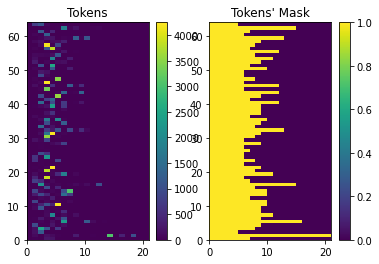

In [ ]:
plt.subplot(1, 2, 1)
c = plt.pcolormesh(example_tokens)
plt.colorbar(c)
plt.title("Tokens")

plt.subplot(1, 2, 2)
c = plt.pcolormesh(example_tokens != 0)
plt.colorbar(c)
plt.title("Tokens' Mask")

plt.show()

In [ ]:
EMBEDDING_DIM = 256
UNITS = 1024

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size: int, embedding_dim: int, enc_units: int) -> None:
    super().__init__()
    self.input_vocab_size = input_vocab_size
    self.embedding_dim = embedding_dim
    self.enc_units = enc_units

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, embedding_dim)

    self.gru = tf.keras.layers.GRU(
      enc_units,
      return_sequences=True,
      return_state=True,
      recurrent_initializer="glorot_uniform",
    )

  def call(self, tokens: tf.Tensor, state=None) -> tf.Tensor:
    shape_checker = ShapeChecker()
    shape_checker(tokens, ("batch", "s"))

    vectors = self.embedding(tokens)
    shape_checker(vectors, ("batch", "s", "embedding_dim"))

    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ("batch", "s", "enc_units"))
    shape_checker(state, ("batch", "enc_units"))

    return output, state

In [ ]:
encoder = Encoder(input_vocab_size=inp_txt_vec.vocabulary_size(), embedding_dim=EMBEDDING_DIM, enc_units=UNITS)

example_tokens = inp_txt_vec(example_input_batch)
example_enc_output, example_enc_state  = encoder(example_tokens)

print(f"example_input_batch shape (batch, ): {example_input_batch.shape}")
print(f"example_tokens shape (batch, s): {example_tokens.shape}")
print(f"example_enc_output shape (batch, s, units): {example_enc_output.shape}")
print(f"example_enc_state shape (batch, units): {example_enc_state.shape}")

example_input_batch shape (batch, ): (64,)
example_tokens shape (batch, s): (64, 21)
example_enc_output shape (batch, s, units): (64, 21, 1024)
example_enc_state shape (batch, units): (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units: int) -> None:
    super().__init__()
    self.units = units
    self.w1 = tf.keras.layers.Dense(units, use_bias=False)
    self.w2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query: tf.Tensor, value: tf.Tensor, mask: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(query, ("batch", "t", "query_units"))
    shape_checker(value, ("batch", "s", "value_units"))
    shape_checker(mask, ("batch", "s"))

    w1_query = self.w1(query)
    shape_checker(w1_query, ("batch", "t", "attn_units"))

    w2_key = self.w2(value)
    shape_checker(w2_key, ("batch", "s", "attn_units"))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    # print("w1_query:", w1_query.shape)
    # print("value:", value.shape)
    # print("w2_key:", w2_key.shape)
    # print("query_mask:", query_mask.shape)
    # print("value_mask:", value_mask.shape)
    context_vector, attention_weights = self.attention(
        inputs=[w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores=True,
    )
    # print("context_vector:", context_vector.shape)
    # print("attention_weights:", attention_weights.shape)
    shape_checker(context_vector, ("batch", "t", "value_units"))
    shape_checker(attention_weights, ("batch", "t", "s"))

    return context_vector, attention_weights

In [ ]:
attention = BahdanauAttention(UNITS)

example_attention_query = tf.random.normal(shape=[example_input_batch.shape[0], 2, 10])

context_vector, attention_weights = attention(query=example_attention_query, value=example_enc_output, mask=example_tokens!=0)

print(f"context_vector shape(batch, query_seq_length, units): {context_vector.shape}")
print(f"context_vector shape(batch, query_seq_length, value_seq_length): {attention_weights.shape}")

context_vector shape(batch, query_seq_length, units): (64, 2, 1024)
context_vector shape(batch, query_seq_length, value_seq_length): (64, 2, 21)


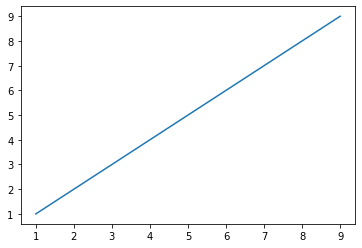

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(np.arange(1, 10), np.arange(1, 10), label="qweqwe")
h, l = ax.get_legend_handles_labels()
plt.show()

In [ ]:
display(h)
display(l)

['qweqwe']

TensorShape([64, 2, 21])

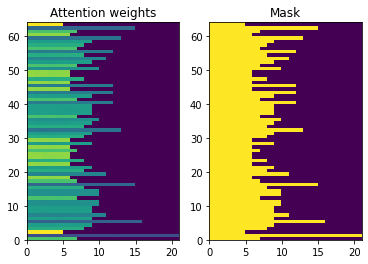

In [ ]:
display(attention_weights.shape)

plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')
plt.show()

In [ ]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

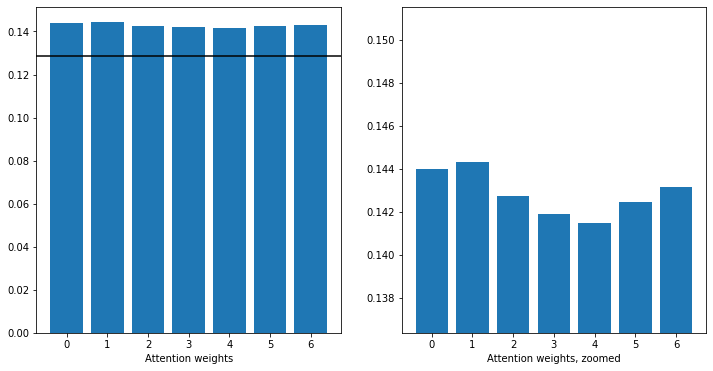

In [ ]:
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

plt.show()

In [ ]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size: int, embedding_dim: int, dec_units: int):
    super().__init__()
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim
    self.dec_units = dec_units

    # For Step 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(
        input_dim=output_vocab_size,
        output_dim=embedding_dim,
    )

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(
        units=dec_units,
        return_state=True,
        return_sequences=True,
        recurrent_initializer="glorot_uniform",
    )

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.wc = tf.keras.layers.Dense(dec_units)

    # For step 5. This fully connected layer produces the logits for each
    self.fc = tf.keras.layers.Dense(dec_units)
  
  def call(
      self, inputs: DecoderInput, state=None
  ) -> Tuple[DecoderOutput, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(inputs.new_tokens, ("batch", "t"))
    shape_checker(inputs.enc_output, ("batch", "s", "enc_units"))
    shape_checker(inputs.mask, ("batch", "s"))

    if state is not None:
      shape_checker(state, ("batch", "dec_units"))

    vectors = self.embedding(inputs.new_tokens)
    shape_checker(vectors, ("batch", "t", "embedding_dim"))

    rnn_output, state = self.gru(vectors, initial_state=state)
    shape_checker(rnn_output, ("batch", "t", "dec_units"))
    shape_checker(state, ("batch", "dec_units"))

    context_vector, attention_weights = self.attention(
        query=rnn_output,
        value=inputs.enc_output,
        mask=inputs.mask,
    )
    shape_checker(context_vector, ("batch", "t", "dec_units"))
    shape_checker(attention_weights, ("batch", "t", "s"))

    attention_vector = self.wc(tf.concat([context_vector, rnn_output], axis=-1))
    shape_checker(attention_vector, ("batch", "t", "dec_units"))

    logits = self.fc(attention_vector)
    shape_checker(logits, ("batch", "t", "dec_units"))

    return (
        DecoderOutput(logits=logits, attention_weights=attention_weights),
        state,
    )

In [ ]:
decoder = Decoder(tgt_txt_vec.vocabulary_size(), EMBEDDING_DIM, UNITS)

In [ ]:
example_output_tokens = tgt_txt_vec(example_target_batch)

start_index = tgt_txt_vec.get_vocabulary().index("[START]")
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [ ]:
print(example_enc_output.shape)
print(first_token.shape)

(64, 21, 1024)
(64, 1)


In [ ]:
decoder_example_out, decoder_example_state = decoder(
    DecoderInput(
        new_tokens=first_token,
        enc_output=example_enc_output,
        mask=example_tokens != 0,
    ),
    state=example_enc_state,
)

print(f'logits shape: (batch_size, t, output_vocab_size) {decoder_example_out.logits.shape}')
print(f'state shape: (batch_size, dec_units) {decoder_example_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 1024)
state shape: (batch_size, dec_units) (64, 1024)


In [ ]:
sampled_token = tf.random.categorical(decoder_example_out.logits[:, 0, :], num_samples=1)

In [ ]:
sampled_token.shape, sampled_token[:10]

(TensorShape([64, 1]), <tf.Tensor: shape=(10, 1), dtype=int64, numpy=
 array([[ 37],
        [ 15],
        [348],
        [572],
        [186],
        [661],
        [157],
        [492],
        [204],
        [997]])>)

In [ ]:
vocab = np.array(tgt_txt_vec.get_vocabulary())
firts_words = vocab[sampled_token]
display(firts_words[:10])

array([['want'],
       ['of'],
       ['afraid'],
       ['cut'],
       ['years'],
       ['piano'],
       ['old'],
       ['lived'],
       ['find'],
       ['public']], dtype='<U16')

In [ ]:
decoder_example_out2, decoder_example_state2 = decoder(
    DecoderInput(
        new_tokens=sampled_token,
        enc_output=example_enc_output,
        mask=example_tokens != 0,
    ),
    state=decoder_example_state,
)

In [ ]:
sampled_token2 = tf.random.categorical(decoder_example_out2.logits[:, 0, :], num_samples=1)
second_words = vocab[sampled_token2]
display(second_words[:10])

array([['team'],
       ['let'],
       ['noise'],
       ['lose'],
       ['be'],
       ['thank'],
       ['looked'],
       ['once'],
       ['coming'],
       ['born']], dtype='<U16')

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
        reduction="none",
    )
  
  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ("batch", "t"))
    shape_checker(y_pred, ("batch", "t", "logits"))

    loss_arr = self.loss(y_true, y_pred)
    shape_checker(loss_arr, ("batch", "t"))

    mask = tf.cast(y_true != 0, tf.float32)
    loss_arr *= mask

    return tf.reduce_sum(loss_arr)

In [ ]:
class TrainTranslator(tf.keras.Model):
  def __init__(
      self,
      input_vocab_size: int,
      output_vocab_size: int,
      src_txt_vec: tf.keras.layers.TextVectorization,
      tgt_txt_vec: tf.keras.layers.TextVectorization,
      use_tf_function: bool,
  ):
    super().__init__()

    self.input_vocab_size = input_vocab_size
    self.output_vocab_size = output_vocab_size

    self.encoder = Encoder(
        input_vocab_size=input_vocab_size,
        embedding_dim=EMBEDDING_DIM,
        enc_units=UNITS,
    )
    self.Decoder = Decoder(
        output_vocab_size=output_vocab_size,
        embedding_dim=EMBEDDING_DIM,
        dec_units=UNITS,
    )

    self.src_txt_vec = src_txt_vec
    self.tgt_txt_vec = tgt_txt_vec
    self.use_tf_function = use_tf_function

    self.shape_checker = ShapeChecker()
  
  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)